In [123]:
import copy
from linearmodels.iv import IV2SLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy as sc
import scipy.signal
import scipy.stats
#import sysidentpy as sipy
from scipy.fft import fft, ifft, fftshift
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.metrics import mutual_info_score

from sysidentpy.metrics import mean_squared_error
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation, compute_cross_correlation
from IPython.display import display, HTML

plt.rc('font', size=30)          # controls default text sizes
plt.rc('axes', titlesize=25)     # fontsize of the axes title
plt.rc('axes', labelsize=25)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=25)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)    # fontsize of the tick labels
plt.rc('legend', fontsize=25)    # legend fontsize
plt.rc('lines', linewidth=3)     # linewidth

df1 = pd.read_csv('data/U3.ASC', sep="\s+", names=['time', 'y', 'u'])
df2 = pd.read_csv('data/U1.ASC', sep="\s+", names=['time', 'y', 'u'])

# cut
df1 = df1.iloc[301:1500]
df2 = df2.iloc[301:930]

# z-normalise
joint_avg_u = np.average(df1['u'].append(df2['u']))
joint_avg_y = np.average(df1['y'].append(df2['y']))
joint_std_u = np.std(df1['u'].append(df2['u']))
joint_std_y = np.std(df1['y'].append(df2['y']))
df1['u'] = (df1['u']-joint_avg_u)/joint_std_u
df1['y'] = (df1['y']-joint_avg_y)/joint_std_y
df2['u'] = (df2['u']-joint_avg_u)/joint_std_u
df2['y'] = (df2['y']-joint_avg_y)/joint_std_y

u_train = np.asarray(df2['u']).reshape(-1, 1)
u_valid = np.asarray(df1['u']).reshape(-1, 1)
y_train = np.asarray(df2['y']).reshape(-1,1)
y_valid = np.asarray(df1['y']).reshape(-1,1)

/tmp/ipykernel_1687/2279324654.py:40: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_avg_u = np.average(df1['u'].append(df2['u']))
/tmp/ipykernel_1687/2279324654.py:41: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_avg_y = np.average(df1['y'].append(df2['y']))
/tmp/ipykernel_1687/2279324654.py:42: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_std_u = np.std(df1['u'].append(df2['u']))
/tmp/ipykernel_1687/2279324654.py:43: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_std_y = np.std(df1['y'].append(df2['y']))


# The four-step IV

# Step 1: estimate the regressors via LS

u_lag1     0.003796
u_lag2     0.012339
u_lag3     0.036380
u_lag4     0.040620
u_lag5     0.022643
u_lag6     0.010425
u_lag7    -0.013678
u_lag8    -0.013465
u_lag9    -0.010855
u_lag10   -0.002846
u_lag11    0.000439
u_lag12    0.007116
u_lag13    0.005317
u_lag14    0.000018
u_lag15    0.001175
u_lag16   -0.001840
u_lag17   -0.004562
u_lag18    0.001003
u_lag19   -0.002254
u_lag20    0.002358
y_lag1     0.790763
y_lag2     0.405258
y_lag3     0.035609
y_lag4    -0.127802
y_lag5    -0.095278
y_lag6    -0.198156
y_lag7     0.064024
y_lag8    -0.037942
y_lag9     0.037868
y_lag10    0.040328
y_lag11    0.049874
y_lag12    0.016394
y_lag13   -0.083652
y_lag14    0.064312
y_lag15   -0.040818
y_lag16   -0.055490
y_lag17    0.028127
y_lag18    0.078363
y_lag19   -0.066950
y_lag20    0.012009
Name: parameter, dtype: float64


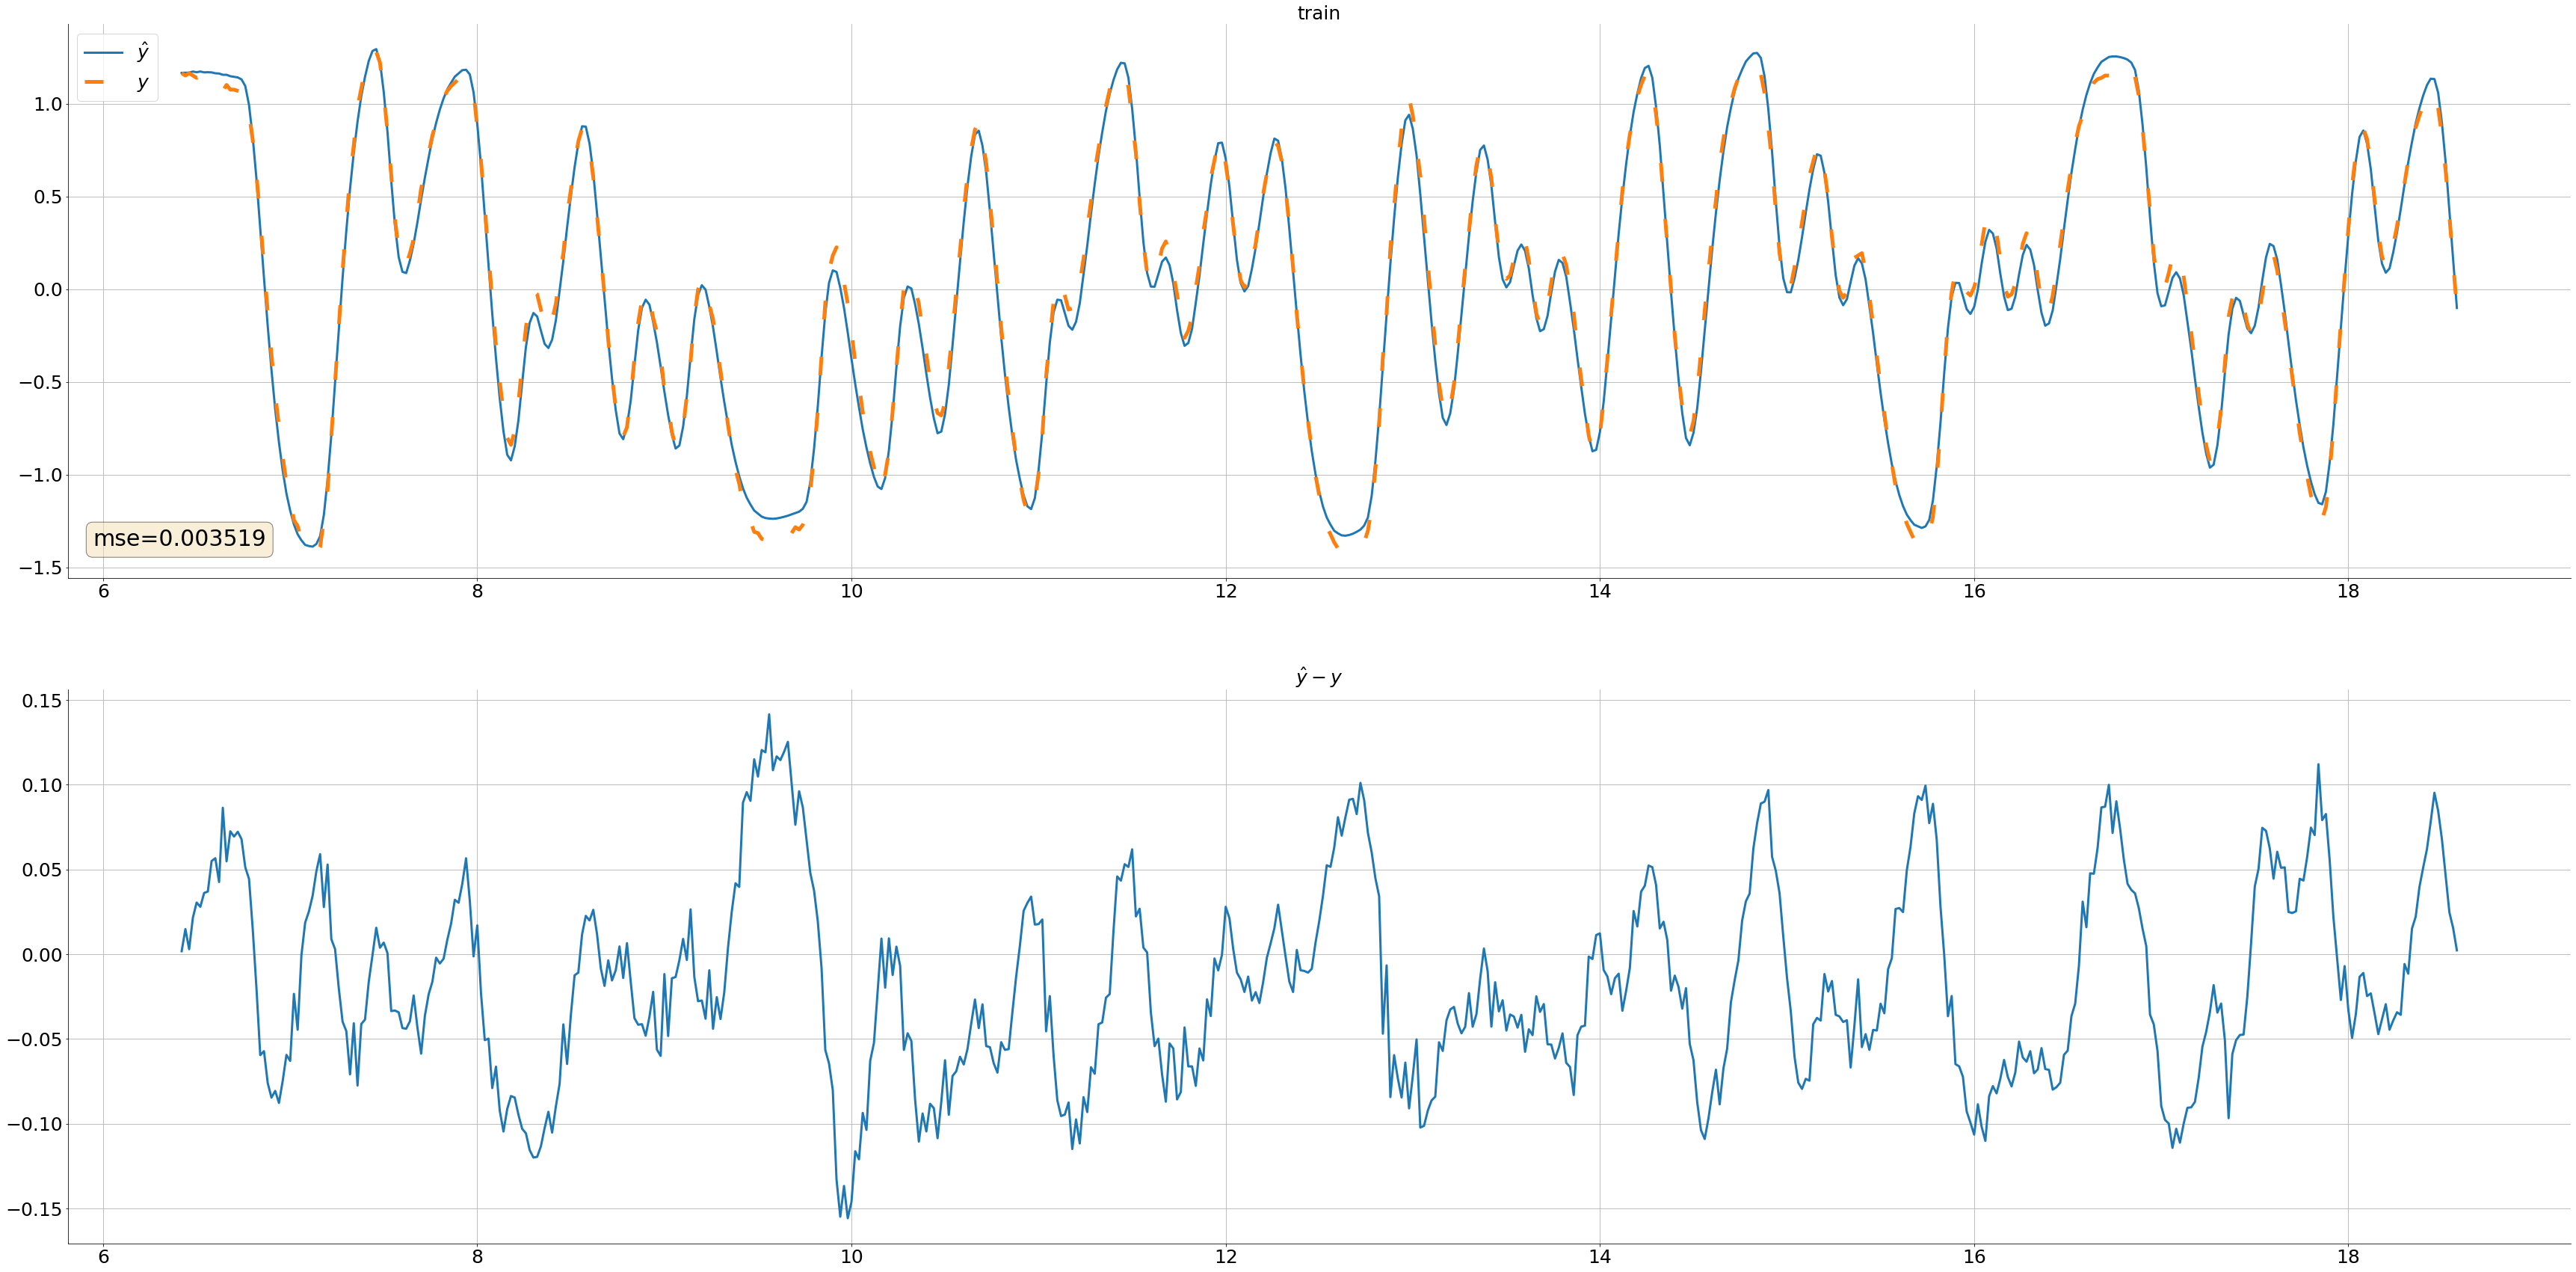

In [124]:
# make a copy of the training data
df_1 = copy.deepcopy(df2)

# define lags
ulag = 20
ylag = ulag
xlag = ulag
wlag = ulag
zlag = ulag
lag = max([ulag,ylag,xlag,wlag,zlag])

# create a list of labels
lagged_u = ['u_lag'+str(i) for i in range(1, ulag+1)]
lagged_y = ['y_lag'+str(i) for i in range(1, ylag+1)]

# adding lags to the dataset
for i in range(1, ylag+1):
    df_1['y_lag'+str(i)] = df_1['y'].shift(i)
for i in range(1, ulag+1):
    df_1['u_lag'+str(i)] = df_1['u'].shift(i)

# dropping NA values (created due to shifting)
df_1 = df_1.dropna()

model_LS_1 = IV2SLS(dependent=df_1['y'],
                    exog=df_1[lagged_u+lagged_y],
                    endog=None,
                    instruments=None) # same as sm.OLS(df_1['y'],df_1[lagged_y+lagged_u])
results_1 = model_LS_1.fit()

#save results
theta_1_df = results_1.params
theta_1 = np.asarray(theta_1_df)
print(theta_1_df)

def simulate(theta, y0, u):
    theta = np.asarray(theta) # shape (ylag+ulag,)
    y0 = np.asarray(y0)       # shape (ylag,)
    u = np.asarray(u)         # shape (l, ulag)

    l = u.shape[0]
    ylag = y0.shape[0]
    y = copy.deepcopy(y0)

    for i in range(l):
        y_next = np.concatenate((u[i,:],y[:ylag])) @ theta # one step ahead prediction
        y = np.concatenate(([y_next],y))

    return y[::-1][ylag:]

# simulate model
yhat_1 = simulate(theta_1, df_1[lagged_y].iloc[0, :], df_1[lagged_u])

y_1_true = np.asarray(df_1['y'])
t_1 = np.asarray(df_1['time'])

# training error
mse_train_1 = mean_squared_error(yhat_1, y_1_true)

fig, axn = plt.subplots(2,1,figsize=(60,30))
axn[0].plot(t_1, yhat_1, label=r'$\hat{y}$')
axn[0].plot(t_1, y_1_true, label=r'$y$', linestyle=(0, (5,10)), lw=5)
axn[0].set_title('train')
axn[0].legend(loc=2)
axn[0].text(0.01, 0.05, 'mse={}'.format(round(mse_train_1,6)), transform=axn[0].transAxes, verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axn[0].grid(True)
axn[1].plot(t_1,yhat_1 - y_1_true)
axn[1].set_title(r'$\hat{y}-y$')
axn[1].grid(True)

## Step 2: generate instruments with the ARX model, IV estimate coefficients theta

### -- Is it a problem that I shorten my PRBS train data for further calcualtions? --

## Step 2.1: generate instruments: $x^{(1)}(t) = G^{(1)}(q)u(t)$

In [125]:
df_2 = copy.deepcopy(df_1)

# split the contribution of G into Gu and Gx where G=Gu/Gy
theta_1_u, theta_1_y = theta_1[:ulag], theta_1[ulag:]

# generate sequence of instruments
l = len(df_2['u'])
u = np.asarray(df_2[lagged_u])
x_1 = np.zeros(l)
for i in range(l):
    x_1[i] = u[i] @ theta_1_u / (u[i] @ theta_1_y)
df_2['x'] = x_1

lagged_x = ['x_lag'+str(i) for i in range(1, xlag+1)]

# adding lags to the dataset
for i in range(1, xlag+1):
    df_2['x_lag'+str(i)] = df_2['x'].shift(i)

df_2 = df_2.dropna()

# solve with IV
model_iv_2 = IV2SLS(dependent=df_2['y'],
                    exog=df_2[lagged_u],
                    endog=df_2[lagged_y],
                    instruments=-df_2[lagged_x] # notice th minus
                    )
results_2 = model_iv_2.fit()

#save results
theta_2_df = results_2.params
theta_2 = np.asarray(theta_2_df)

## Step 2.2: Estimate $\theta^{(2)}$

In [126]:
df_2 = copy.deepcopy(df_1)
df_2['x'] = x_1


# chose the xlag equal to ylag, so that the zeta * fi.T is a square matrix (probably not neccessary for IV2SLS)
xlag = ylag

# create a list of labels for x
lagged_x = ['x_lag'+str(i) for i in range(1, xlag+1)]

# adding lags of x to the dataset
for i in range(1, xlag+1):
    df_2['x_lag' + str(i)] = df_2['x'].shift(i)

# dropping NA values (created due to shifting)
df_2 = df_2.dropna()

# --------------------------------

model_iv_2 = IV2SLS(dependent=df_2['y'],
                    exog=df_2[lagged_u],
                    endog=df_2[lagged_y],
                    instruments=-df_2[lagged_x] # notice th minus
                    )
results_2 = model_iv_2.fit()

theta_2_df = results_2.params
print(theta_2_df)

u_lag1     0.015116
u_lag2     0.013702
u_lag3     0.013628
u_lag4     0.057176
u_lag5     0.075683
u_lag6     0.007861
u_lag7    -0.043172
u_lag8    -0.045259
u_lag9    -0.006956
u_lag10    0.145880
u_lag11    0.027607
u_lag12   -0.082401
u_lag13   -0.045003
u_lag14   -0.053760
u_lag15    0.177838
u_lag16    0.021068
u_lag17   -0.006213
u_lag18   -0.064557
u_lag19   -0.055748
u_lag20    0.206784
y_lag1     0.432497
y_lag2     0.156924
y_lag3     2.008969
y_lag4    -1.212916
y_lag5    -2.187660
y_lag6     2.750055
y_lag7    -3.349500
y_lag8     4.054266
y_lag9    -1.627062
y_lag10    0.097570
y_lag11   -0.988872
y_lag12    1.028506
y_lag13   -1.219749
y_lag14   -0.434671
y_lag15    3.601835
y_lag16   -2.758355
y_lag17    0.926529
y_lag18   -2.611834
y_lag19    1.927947
y_lag20   -0.105726
Name: parameter, dtype: float64


# Step 3: postulate AR model to predict intermediate vector $\omega$ and find a linear filter $L(q)$

w_lag1    -0.013384
w_lag2    -0.001861
w_lag3     0.002765
w_lag4     0.003672
w_lag5     0.004365
w_lag6    -0.006315
w_lag7    -0.001435
w_lag8     0.004605
w_lag9     0.000347
w_lag10   -0.003089
w_lag11   -0.003152
w_lag12    0.006166
w_lag13    0.003900
w_lag14   -0.004330
w_lag15   -0.001197
w_lag16   -0.003551
w_lag17    0.003318
w_lag18   -0.001717
w_lag19   -0.004824
w_lag20    0.004175
w_lag21   -0.007032
w_lag22    0.006415
w_lag23    0.003036
w_lag24   -0.001288
w_lag25   -0.002424
w_lag26   -0.000909
w_lag27    0.000326
w_lag28    0.004943
w_lag29   -0.004415
w_lag30    0.006625
w_lag31   -0.007747
w_lag32    0.006309
w_lag33    0.004302
w_lag34    0.000565
w_lag35   -0.002049
w_lag36   -0.000748
w_lag37   -0.003449
w_lag38    0.000014
w_lag39   -0.002299
w_lag40    0.008914
Name: parameter, dtype: float64


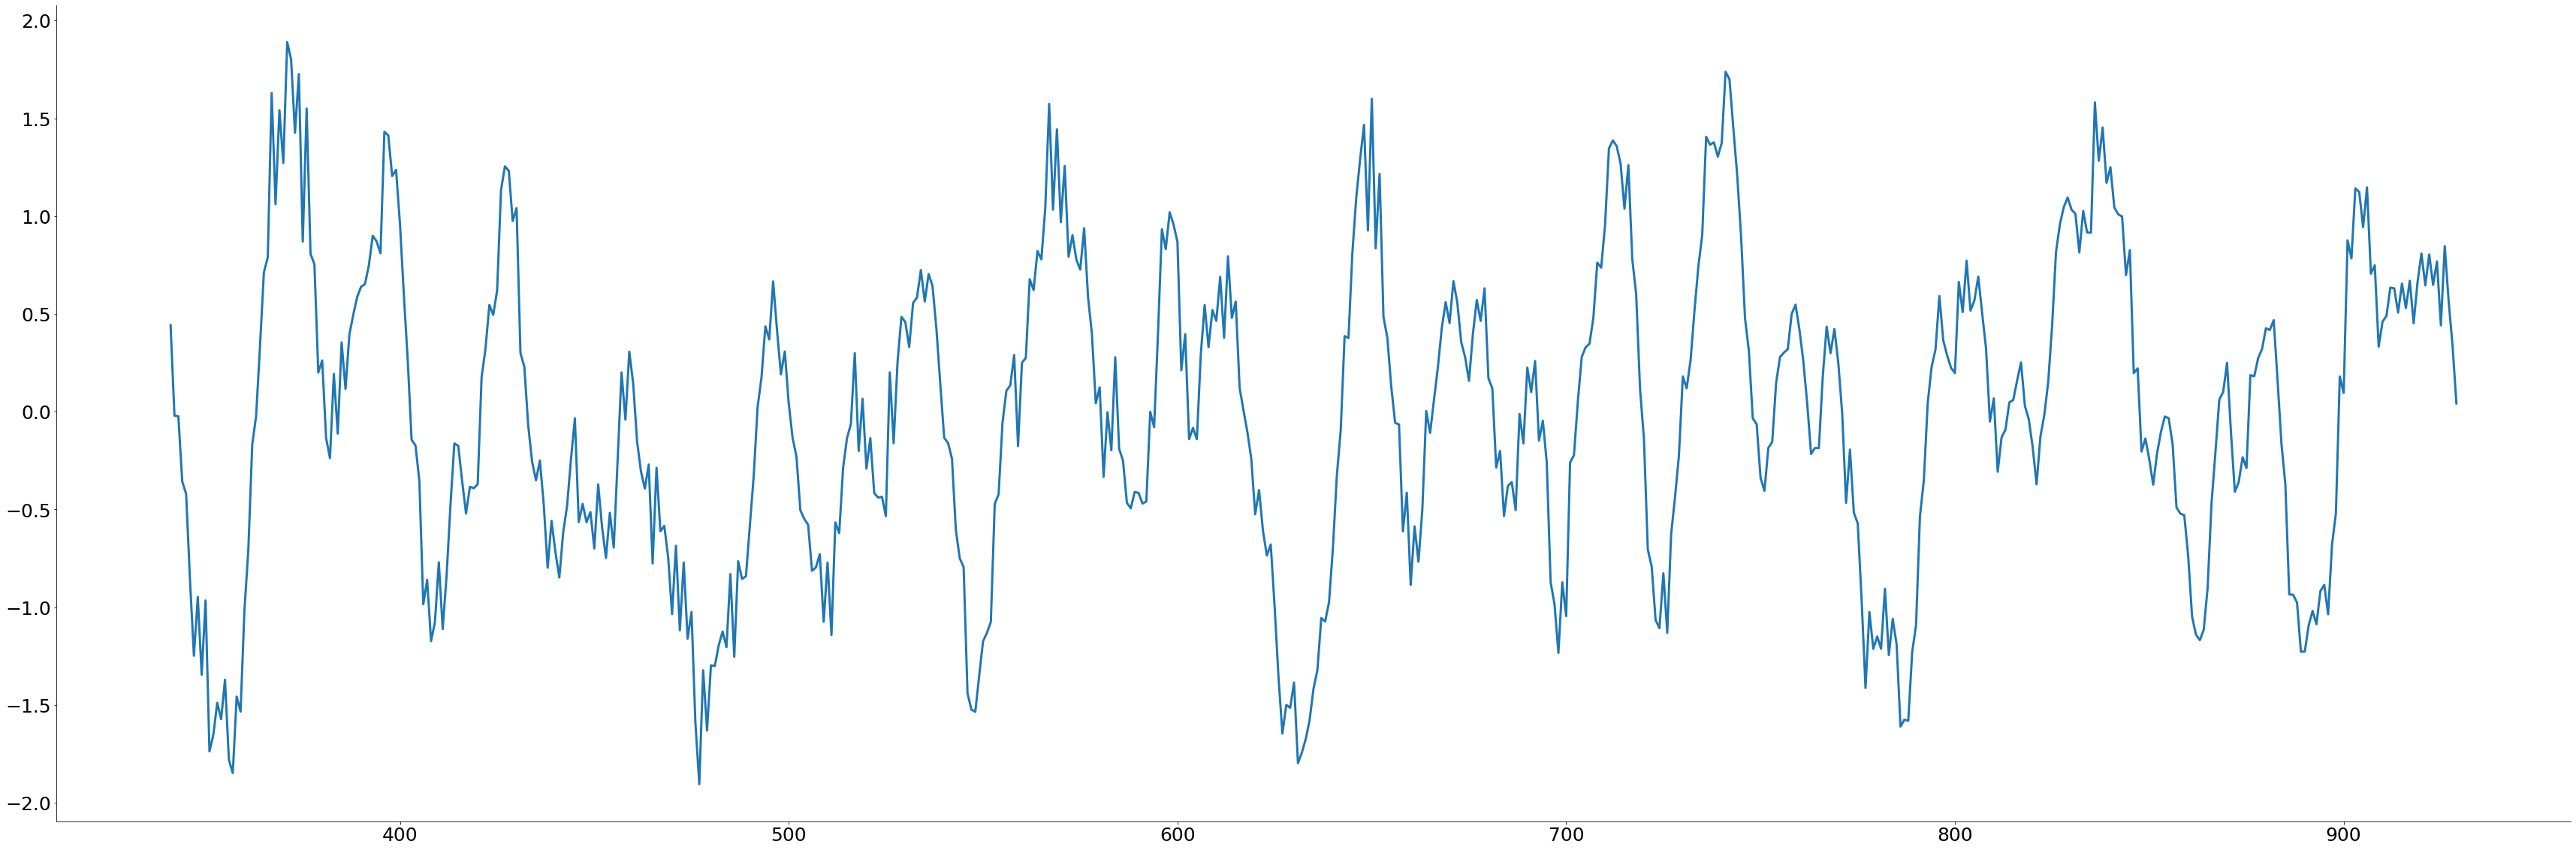

In [127]:
wlag = 2* ulag

df_3 = copy.deepcopy(df_2)

df_3['w'] = np.asarray(df_3[lagged_u + lagged_y]) @ theta_2

plt.figure(figsize=(60,20))
plt.plot(df_3['w'])

# create a list of labels for x
lagged_w = ['w_lag'+str(i) for i in range(1, wlag+1)]

# adding lags of w to the dataset
for i in range(1, wlag+1):
    df_3['w_lag' + str(i)] = df_3['w'].shift(i)

# dropping NA values (created due to shifting)
df_3 = df_3.dropna()

# yhat_2 = w_2
# y_2_true = np.asarray(df_3['y'])
# t_2 = np.asarray(df_3['time'])
#
# # training error
# mse_train_2 = mean_squared_error(yhat_1, y_1_true)
#
# fig, axn = plt.subplots(2,1,figsize=(60,30))
# axn[0].plot(t_2, yhat_2, label=r'$\hat{y}$')
# axn[0].plot(t_2, y_2_true, label=r'$y$', linestyle=(0, (5,10)), lw=5)
# axn[0].set_title('train')
# axn[0].legend(loc=2)
# axn[0].text(0.01, 0.05, 'mse={}'.format(round(mse_train_1,6)), transform=axn[0].transAxes, verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
# axn[0].grid(True)
# axn[1].plot(t_2,yhat_2 - y_2_true)
# axn[1].set_title(r'$\hat{y}-y$')
# axn[1].grid(True)

#e = np.asarray(df_3['y']) - np.asarray(df_3['w'])
e = (yhat_1 - y_1_true)[-len(df_3['w']):]

model_LS_3 = IV2SLS(dependent=e,
                    exog=df_3[lagged_w],
                    endog=None,
                    instruments=None) # same as sm.OLS(df_1['y'],df_1[lagged_w])
results_3 = model_LS_3.fit()

L_df = results_3.params
print(L_df)

## Step 4

In [128]:
df_4 = copy.deepcopy(df_3)

# split the contribution of G into Gu and Gx where G=Gu/Gy
theta_2_u, theta_2_y = theta_2[:ulag], theta_2[ulag:]

# generate sequence of instruments
l = len(df_4['u'])
u = np.asarray(df_4[lagged_u])
x_2 = np.zeros(l)
for i in range(l):
    x_2[i] = u[i] @ theta_2_u / (u[i] @ theta_2_y)
df_4['x2'] = x_2

lagged_x2 = ['x2_lag'+str(i) for i in range(1, xlag+1)]

# adding lags to the dataset
for i in range(1, xlag+1):
    df_4['x2_lag'+str(i)] = df_4['x2'].shift(i)

df_4 = df_4.dropna()

df_4['z'] = np.hstack((-np.asarray(df_4[lagged_x2]),np.asarray(df_4[lagged_u]))) @ np.asarray(L_df)

u_lag1     0.014817
u_lag2     0.021681
u_lag3     0.073486
u_lag4     0.173089
u_lag5     0.276563
u_lag6     0.381880
u_lag7     0.419002
u_lag8     0.375103
u_lag9     0.261538
u_lag10    0.108387
u_lag11   -0.013018
u_lag12   -0.056647
u_lag13    0.031471
u_lag14    0.156261
u_lag15    0.245573
u_lag16    0.259950
u_lag17    0.209317
u_lag18    0.119422
u_lag19    0.048421
u_lag20    0.023923
y_lag1    -1.463384
y_lag2    -0.614412
y_lag3    -0.453183
y_lag4    -0.126309
y_lag5     1.043917
y_lag6     1.923873
y_lag7     0.904214
y_lag8     0.233736
y_lag9    -1.559690
y_lag10   -2.485343
y_lag11   -1.095713
y_lag12    0.354975
y_lag13    1.287903
y_lag14    0.672991
y_lag15    0.939289
y_lag16   -0.253621
y_lag17   -1.178087
y_lag18   -0.064771
y_lag19    0.898719
y_lag20   -0.676585
Name: parameter, dtype: float64


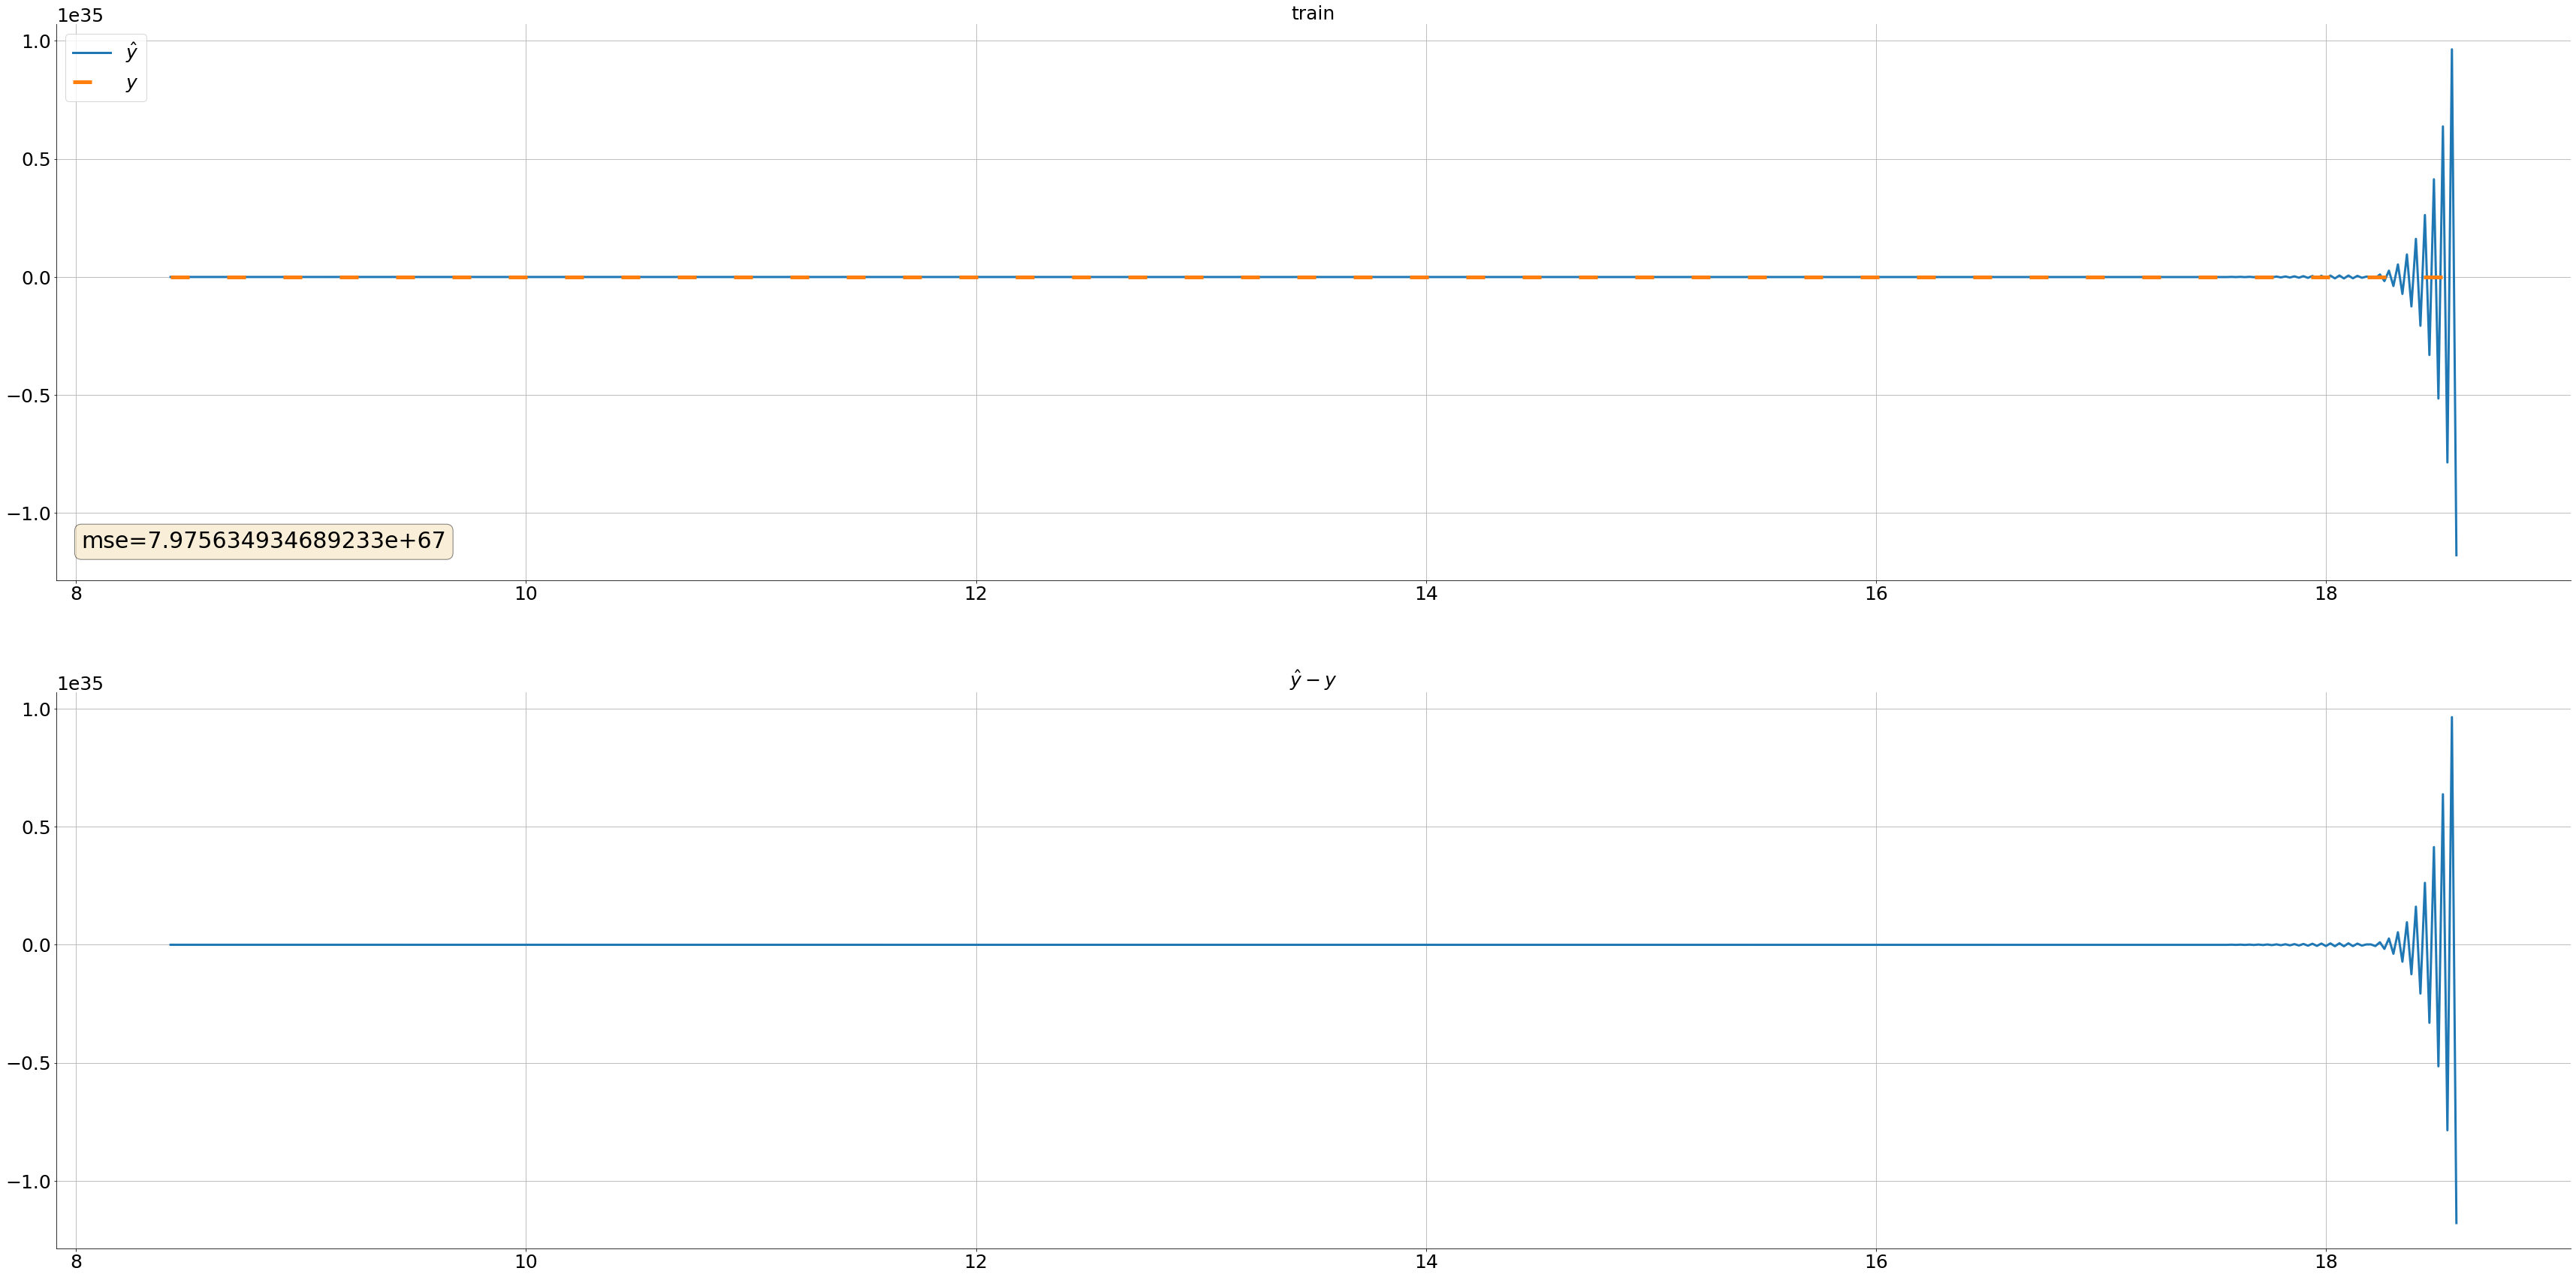

In [129]:
df_5 = copy.deepcopy(df_4)

lagged_z = ['z_lag'+str(i) for i in range(1, zlag+1)]

# adding lags to the dataset
for i in range(1, zlag+1):
    df_5['z_lag'+str(i)] = df_5['z'].shift(i)

df_5 = df_5.dropna()

model_iv_4 = IV2SLS(dependent=df_5['y'],
                    exog=df_5[lagged_u],
                    endog=df_5[lagged_y],
                    instruments=df_5[lagged_z] # notice th minus
                    )
results_4 = model_iv_4.fit()

theta_4_df = results_4.params
print(theta_4_df)

# simulate model
yhat_4 = simulate(theta_4_df, df_5[lagged_y].iloc[0, :], df_5[lagged_u])

y_4_true = np.asarray(df_5['y'])
t_4 = np.asarray(df_5['time'])

# training error
mse_train_1 = mean_squared_error(yhat_4, y_4_true)

fig, axn = plt.subplots(2,1,figsize=(60,30))
axn[0].plot(t_4, yhat_4, label=r'$\hat{y}$')
axn[0].plot(t_4, y_4_true, label=r'$y$', linestyle=(0, (5,10)), lw=5)
axn[0].set_title('train')
axn[0].legend(loc=2)
axn[0].text(0.01, 0.05, 'mse={}'.format(round(mse_train_1,6)), transform=axn[0].transAxes, verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axn[0].grid(True)
axn[1].plot(t_4,yhat_4 - y_4_true)
axn[1].set_title(r'$\hat{y}-y$')
axn[1].grid(True)